# Simulationg fibrosis

In [1]:
import numpy as np 
import scipy as sp
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN


import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx

from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt
import diffrax
import jax
from jax import lax, vmap, jit
import jax.random as random
from jax.experimental import sparse


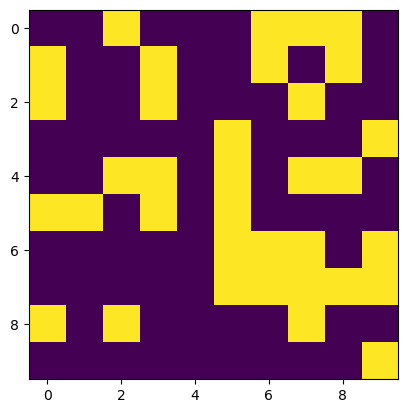

In [15]:


def generate_laplacian_with_central_blocks(N, M, conduction_block_threshold, m, sparse_matrix=False, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold

    # Add conduction blocks on the central column
    central_col = M // 2
    middle_row = N // 2
    top_start = max(0, middle_row - m // 2)
    bottom_end = min(N, middle_row + (m + 1) // 2)

    for row in range(top_start, bottom_end):
        conduction_blocks[row, central_col] = True

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, 0.5),  # up
        (1, 0, 0.5),  # down
        (0, -1, 0.5),  # left
        (0, 1, 0.5),  # right
        (-1, -1, 0.25),  # top-left
        (-1, 1, 0.25),  # top-right
        (1, -1, 0.25),  # bottom-left
        (1, 1, 0.25),  # bottom-right
    ]

    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

        # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)

        # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

        # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

        # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))

    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix

    if sparse_matrix:
        return laplacian_matrix, conduction_blocks
    else:
        return laplacian_matrix.todense(), conduction_blocks


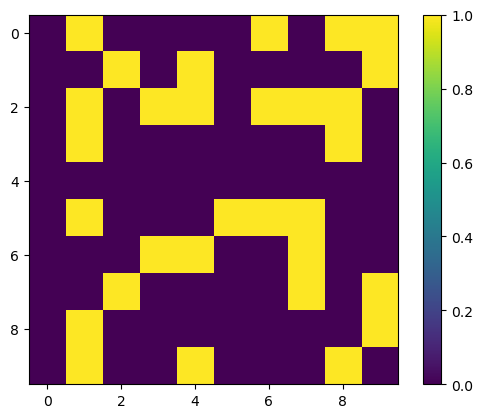

In [12]:

def generate_laplacian(N, M, conduction_block_threshold, sparse_matrix=False, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks

N_x=10
N_y=10
L1, c1=generate_laplacian(N_x, N_x, 0.3, sparse_matrix=True,seed=2)
plt.imshow(c1)
plt.colorbar()

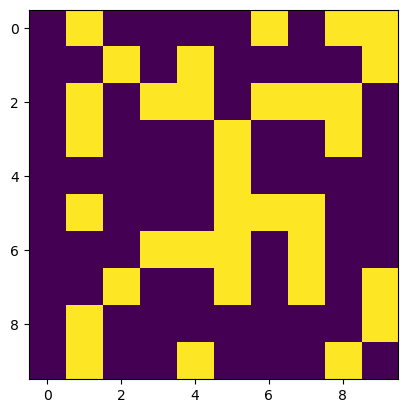

In [ ]:
# this still doesn't work as wanted because it only adds half of the desired
#amount of conduction blocks

def update_laplacian_near_column(N, M, original_laplacian, conduction_blocks, num_blocks, sparse_matrix=False):
    """
    Recalculate the Laplacian and adjacency matrix near the central column
    after adding non-conductive blocks.

    Parameters:
    N (int): Number of rows in the grid.
    M (int): Number of columns in the grid.
    original_laplacian (jax.experimental.sparse.bcsr.BCSR): Original Laplacian matrix.
    conduction_blocks (jnp.ndarray): Initial conduction block grid (N x M).
    num_blocks (int): Number of conduction blocks to add in the central column.
    sparse_matrix (bool): Whether to return a sparse Laplacian.

    Returns:
    jax.experimental.sparse.bcsr.BCSR: Updated Laplacian matrix.
    jax.numpy.ndarray: Updated conduction blocks.
    """
    central_col = M // 2
    central_row = N // 2
    
    # Compute rows to update, starting from the middle and spreading up and down
    rows_to_update = []
    blocks_added = 0
    i = 0
    while blocks_added < num_blocks and i < N:
        up_row = central_row - (i // 2)
        down_row = central_row + (i // 2) + (i % 2)
        if up_row >= 0 and not conduction_blocks[up_row, central_col]:
            rows_to_update.append(up_row)
            blocks_added += 1
        if blocks_added < num_blocks and down_row < N and not conduction_blocks[down_row, central_col]:
            rows_to_update.append(down_row)
            blocks_added += 1
        i += 1

# Ensure we have exactly num_blocks rows to update
    if len(rows_to_update) > num_blocks:
        rows_to_update = rows_to_update[:num_blocks]


    # Update the conduction blocks immutably
    conduction_blocks = conduction_blocks.at[(rows_to_update, central_col)].set(True)

    # Recalculate adjacency structure for affected rows and neighboring nodes
    adj_rows, adj_cols, adj_data = [], [], []
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]

    for row in rows_to_update:
        for di, dj, weight in neighbors:
            ni, nj = row + di, central_col + dj
            if 0 <= ni < N and 0 <= nj < M:
                if not conduction_blocks[ni, nj] and not conduction_blocks[row, central_col]:
                    adj_rows.append(node_index(row, central_col))
                    adj_cols.append(node_index(ni, nj))
                    adj_data.append(weight)

    # Create adjacency and degree matrices for the updated nodes
    num_nodes = N * M
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    updated_laplacian = degree_matrix - adj_matrix

    # Convert the original Laplacian to dense format for modification
    original_laplacian_dense = original_laplacian.todense()

    # Add updates to the original Laplacian
    combined_laplacian = original_laplacian_dense + updated_laplacian.todense()

    if sparse_matrix:
        return sparse.BCSR.fromdense(jnp.array(combined_laplacian)), conduction_blocks
    else:
        return combined_laplacian, conduction_blocks

L2, c2 = update_laplacian_near_column(N_x, N_y, L1, c1, 6, sparse_matrix=True)
plt.imshow(c2)


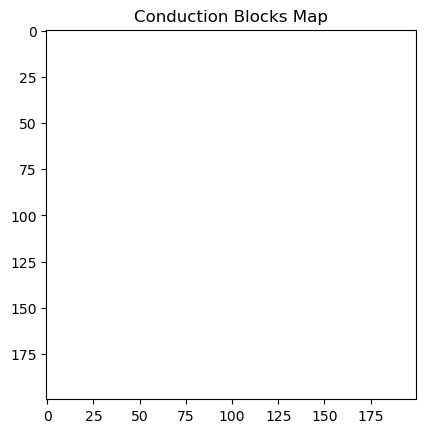

In [3]:
from matplotlib.colors import ListedColormap

# Replace True values with NaN
c1_nan = np.where(c1, np.nan, c1)
# Create c_map where NaN in c1_nan is 1 and False is 0
c_map = np.where(np.isnan(c1_nan), 1, 0)
# Define a custom colormap with white for 0 and blue for 1
color = ListedColormap(['white', 'blue'])

plt.imshow(c_map, cmap=color)
#plt.colorbar()
plt.title('Conduction Blocks Map')
plt.show()


In [4]:

def FHN_graph(t, y, args):
    N, a, b, e, Du,L, c_blocks= args 
    u = y[:N]
    v = y[N:]
    
    du = a*u*(u-b)*(1-u) - Du*(L@u) - v 
    dv = e*(u-v)

    return jnp.append(du,dv)


In [38]:
#switched from Dopri5 to Dopri8 cause the former was getting stuck

def solve_heart(y0='wave',N=200*200, a=3, b=0.2, e=1e-2, Du=0.2, T=300, L=L1,c1=c1, max_steps=1000000,dts=6000,
                solver=diffrax.Dopri8(), rtol=1e-6, atol=1e-7, dt0=1e-2):
    indices = jnp.where((jnp.arange(N) % 50 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)
    term = ODETerm(FHN_graph)
    saveat = SaveAt(ts=jnp.linspace(0, T, dts))  # Reduced save points
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)

    # Switch to a less memory-intensive solver, e.g., Tsit5 or BDF
    sol = diffeqsolve(term, solver, 0, T, dt0, y0, args=(N, a, b, e, Du, L, c1),
                      saveat=saveat, max_steps=max_steps, stepsize_controller=stepsize_controller)

    return sol


In [5]:
N=N_x*N_x
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0,sparse_matrix=True, seed=2)

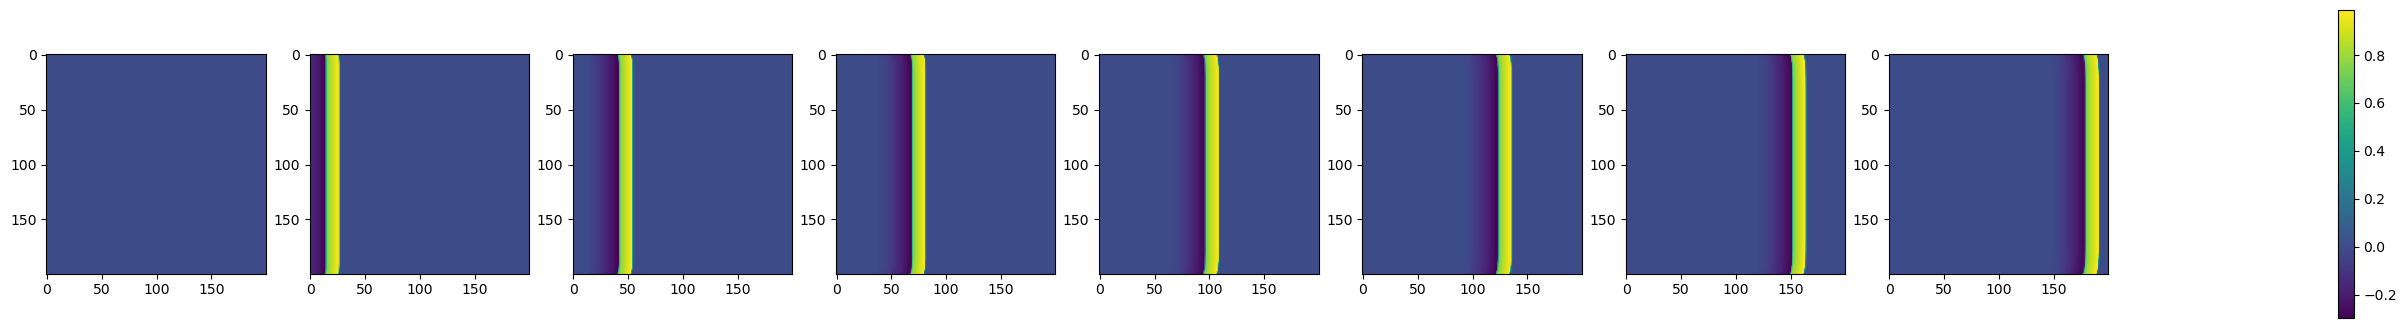

In [6]:

N_y=200
N=N_x*N_y
dts=1400
sol = solve_heart(T=1400,a=3,b=0.05,Du=0.04, L=L1,c1=c1, dts=dts)
fig, axs = plt.subplots(1,9,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*len(sol.ts))),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])
#To have arrhythmias; a=3, b=0.05, Du=0.04, cd=0.5. With cd=0.59 I don't have conduction anymore

In [8]:
def threshold_matrix(matrix: jnp.ndarray, threshold: float) -> jnp.ndarray:
    """
    Scans a JAX matrix and returns a binary matrix where elements above 
    the threshold are 1 and elements below or equal to the threshold are 0.
    
    Parameters:
    matrix (jnp.ndarray): Input JAX matrix.
    threshold (float): Threshold value.
    
    Returns:
    jnp.ndarray: A binary matrix of the same shape as the input.
    """
    # Use jax.numpy.where to create a binary matrix
    return jnp.where(matrix > threshold, 1, 0)




In [58]:
N_y=50
N_x=50
N=N_x*N_y
dts=500
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold= 0, sparse_matrix=True,seed=2)
sol = solve_heart(N=N,T=500,a=3,b=0.05,Du=0.04, L=L1,c1=c1, dts=dts)

In [59]:
u_sol = sol.ys[:,:N].T 
binary=threshold_matrix(u_sol,0.08)
binary=binary.reshape(N_x,N_y,-1)


C:\Users\pelli\AppData\Local\Temp\ipykernel_39240\2244634534.py:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap.set_under(color='white')


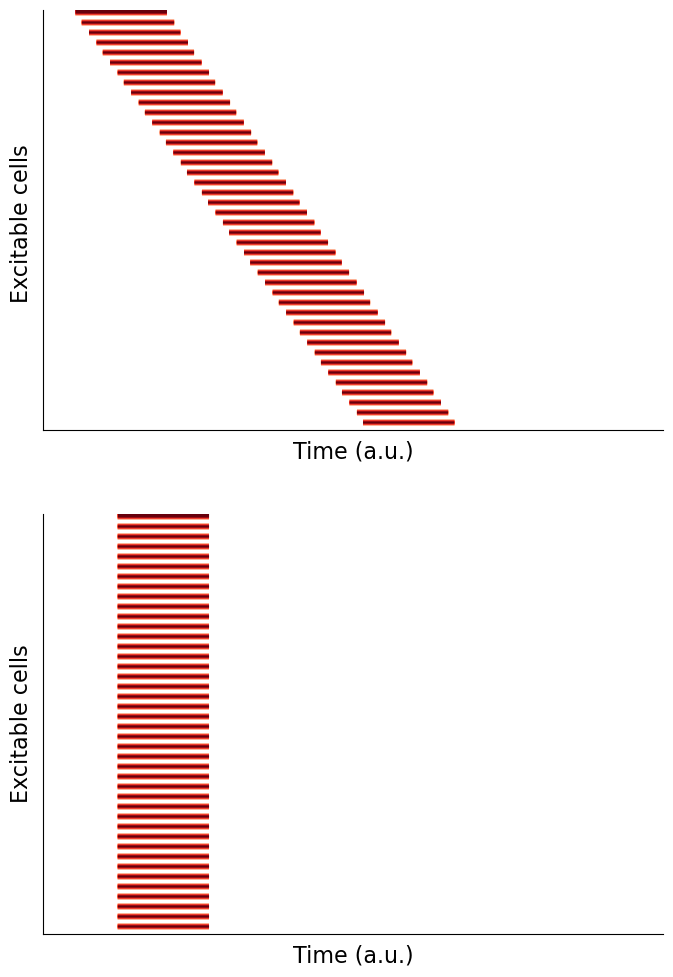

In [60]:
# Get the specific slices
data1 = binary[20, 4:(N_y-4), :]
data2 = binary[4:(N_y-4), 10, :]

# Add blank rows between binary rows for data1
N1, T1 = data1.shape
gap1 = 1  # Gap size (number of blank rows)
data1_with_blanks = np.zeros((N1 * (gap1 + 1), T1))
for i in range(N1):
    data1_with_blanks[i * (gap1 + 1), :] = data1[i, :]

# Add blank rows between binary rows for data2
N2, T2 = data2.shape
gap2 = 1  # Gap size (number of blank rows)
data2_with_blanks = np.zeros((N2 * (gap2 + 1), T2))
for i in range(N2):
    data2_with_blanks[i * (gap2 + 1), :] = data2[i, :]

# Create a custom colormap (white for 0, red for 1)
cmap = plt.cm.Reds
cmap.set_under(color='white')

# Plot the data
plt.figure(figsize=(8, 12))

# Plot data1
plt.subplot(2, 1, 1)
plt.imshow(data1_with_blanks, cmap=cmap, vmin=0.1, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells ", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

# Plot data2
plt.subplot(2, 1, 2)
plt.imshow(data2_with_blanks, cmap=cmap, vmin=0.1, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

plt.show()

C:\Users\pelli\AppData\Local\Temp\ipykernel_39240\486696935.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap.set_under(color='white')


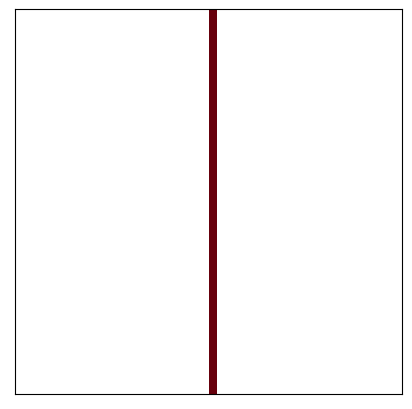

In [54]:

box1 = np.zeros((50, 50))
box1[25, :] = 1  # Set the 26th row to ones

# Create the second box with a column of ones
box2 = np.zeros((50, 50))
box2[:, 25] = 1  # Set the 26th column to ones

# Create a custom colormap (white for 0, red for 1)
cmap = plt.cm.Reds
cmap.set_under(color='white')

# Plot the data
plt.figure(figsize=(5, 5))
'''
# Plot box1

plt.imshow(box1, cmap=cmap, vmin=0.1, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
'''
# Plot box2
plt.imshow(box2, cmap=cmap, vmin=0.1, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks

plt.show()

248 858


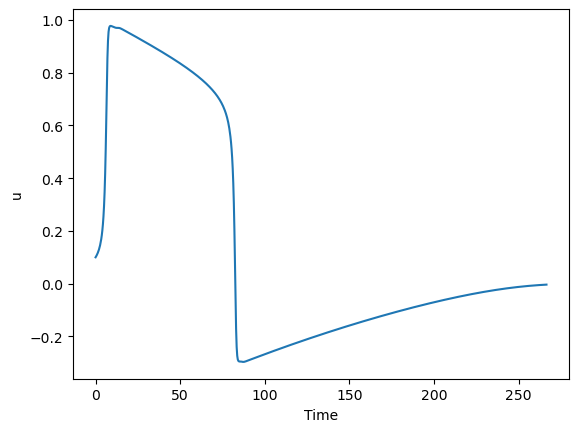

In [36]:
plt.plot(sol.ts[:800], u_sol[0,0,:800])
plt.xlabel('Time')
plt.ylabel('u')
first_below_zero =  np.argmax(u_sol[0,0,:] < 0)

again_zero=first_below_zero + np.argmax(u_sol[0,0,first_below_zero:]>0)
print(first_below_zero, again_zero)

190 413 1028


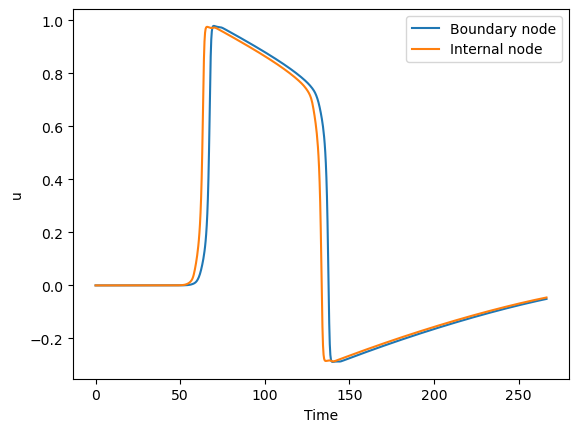

In [49]:
plt.plot(sol.ts[:800], u_sol[0,10,:800], label='Boundary node')
#plt.plot(sol.ts[:800], u_sol[,10,:800], label='Internal node')
plt.plot(sol.ts[:800], u_sol[100,10,:800], label='Internal node ')
plt.xlabel('Time')
plt.ylabel('u')
plt.legend()
first_above_zero =  np.argmax(u_sol[0,10,:] >0.08 )
first_below_zero =  np.argmax(u_sol[0,10,:] < 0)

again_zero=first_below_zero + np.argmax(u_sol[0,10,first_below_zero:]>0)
print(first_above_zero,first_below_zero, again_zero)

178 401 1011


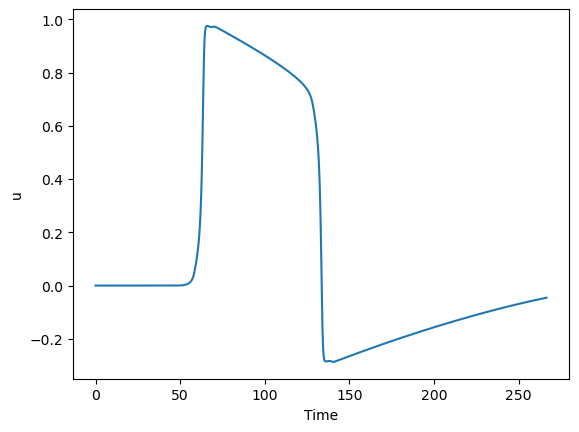

In [32]:
plt.plot(sol.ts[:800], u_sol[10,10,:800])
plt.xlabel('Time')
plt.ylabel('u')
first_above_zero =  np.argmax(u_sol[10,10,:] >0.08 )
first_below_zero =  np.argmax(u_sol[10,10,:] < 0)

again_zero=first_below_zero + np.argmax(u_sol[10,10,first_below_zero:]>-0.0)
print(first_above_zero,first_below_zero, again_zero)

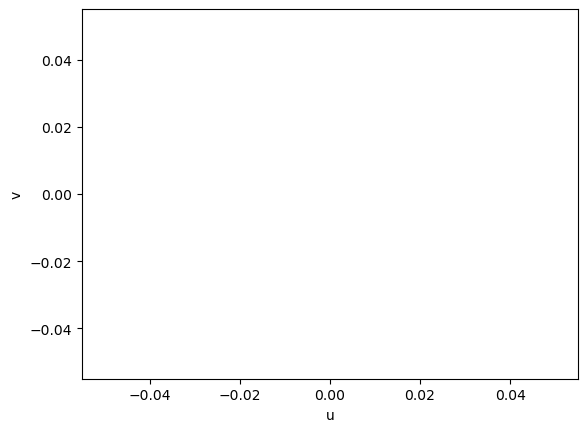

20010


In [25]:
u_sol = sol.ys[:,:N].T 
v_sol = sol.ys[:,N:].T
c1 = c1.flatten()

#u_plot = np.array(u_sol[~c1, :])
#v_plot = np.array(v_sol[~c1, :])
u_plot = np.array(u_sol[c1, :])
v_plot = np.array(v_sol[c1, :])

# Plotting function
def plot_uv(u, v):
    plt.plot(u, v)  

# Plot each (u, v) pair for a subsample
#subsample_indices = np.random.choice(len(u_plot), size=100, replace=False)
for idx in range(len(u_plot)):
    plot_uv(u_plot[idx], v_plot[idx])

plt.xlabel('u')
plt.ylabel('v')
plt.show()
print(len(u_plot))

In [68]:

'''
#functions calculating average entropy in the frequency power spectrum of elements 
#which are not conduction blocks

@jit
def calculate_entropy(power_spectrum):
    epsilon = 1e-12
    power_spectrum /= jnp.sum(power_spectrum) + epsilon
    entropy = -jnp.sum(power_spectrum * jnp.log(power_spectrum + epsilon))
    return entropy

@jit
def process_element(array, i, j):
    fft_result = jnp.fft.fft(array[i, j, :])
    power_spectrum = jnp.abs(fft_result) ** 2
    entropy = calculate_entropy(power_spectrum)
    return entropy


def average_entropy(array, mask):
    N, _, T = array.shape
    valid_indices = jnp.array(jnp.where(~mask)).T
    
    vectorized_process = vmap(lambda idx: process_element(array, idx[0], idx[1]))
    entropy_values = vectorized_process(valid_indices)
    
    average_entropy = jnp.mean(entropy_values)
    return average_entropy, entropy_values
u_sol=u_sol.reshape(N_x, N_y, dts)
v_sol=v_sol.reshape(N_x, N_y, dts)
mask = jnp.zeros((N_x, N_y), dtype=bool)
ent, ent_matrix= average_entropy(u_sol, mask)

'''



@jit
def calculate_entropy(power_spectrum):
    epsilon = 1e-12  # Small constant to prevent division by zero
    power_spectrum /= jnp.sum(power_spectrum) + epsilon  # Normalize power spectrum
    entropy = -jnp.sum(power_spectrum * jnp.log(power_spectrum + epsilon))  # Calculate entropy
    return jnp.abs(entropy), power_spectrum  # Ensure entropy is not negative

@jit
def process_element(array, i, j):
    fft_result = jnp.fft.fft(array[i, j, :])
    fft_result_shifted = jnp.fft.fftshift(fft_result)  # Shift the zero-frequency component to the center
    power_spectrum = jnp.abs(fft_result_shifted) ** 2
    entropy, power_spectrum = calculate_entropy(power_spectrum)
    return entropy

def average_entropy(array):
    N, M, T = array.shape
    
    # Vectorized processing of all elements
    vectorized_process = vmap(lambda i: vmap(lambda j: process_element(array, i, j))(jnp.arange(M)))(jnp.arange(N))
    
    average_entropy = jnp.mean(vectorized_process)
    return average_entropy


In [81]:
u_sol=u_sol.reshape(N_x, N_y, dts)
v_sol=v_sol.reshape(N_x, N_y, dts)
mask = jnp.zeros((N_x, N_y), dtype=bool)
ent= average_entropy(u_sol)
print(ent)

2.0185232


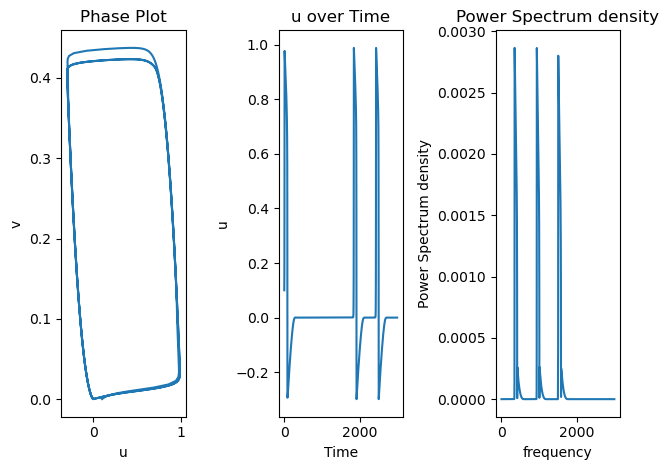

3.9333706


In [82]:
u_sol=u_sol.reshape(N_x*N_y,-1)
v_sol=v_sol.reshape(N_x*N_y,-1)
power_values = jnp.abs(jnp.fft.fftshift(u_sol[20000,:])) ** 2
power_values=power_values/np.sum(power_values)
# Plot u vs v
plt.subplot(1, 3, 1)
plt.plot(u_sol[20000, :], v_sol[20000, :])
plt.xlabel('u')
plt.ylabel('v')
plt.title('Phase Plot')

# Plot u over time
plt.subplot(1, 3, 2)
plt.plot(jnp.linspace(0, 3000, dts), u_sol[20000, :])
plt.xlabel('Time')
plt.ylabel('u')
plt.title('u over Time')

# Plot v over time
plt.subplot(1, 3, 3)
plt.plot(jnp.linspace(0, 3000, dts), power_values)
plt.xlabel('frequency')
plt.ylabel('Power Spectrum density')
plt.title('Power Spectrum density')

plt.tight_layout()
plt.show()

ent_matrix=ent_matrix.flatten()
print(ent_matrix[20000])

In [ ]:
results_u = []
results_v=[]
dts=6000
# Loop over conduction threshold values
for conduction_threshold in jnp.arange(0, 0.9, 0.01):
    seed = int(conduction_threshold * 10)
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=conduction_threshold,boundary_condition="no-flux",sparse_matrix=True, seed=seed)
    
    sol = solve_heart(T=3000,a=3,b=0.05,Du=0.04, L=L1, c1=c1,dts=dts)
    u_sol = sol.ys[:,:N].T 
    v_sol = sol.ys[:,N:].T

    u_sol=u_sol.reshape(N_x, N_y, dts)
    v_sol=v_sol.reshape(N_x, N_y, dts)

    
    avg_entropy_u = average_entropy(u_sol, c1)
    avg_entropy_v = average_entropy(v_sol, c1)
    
    results_u.append( avg_entropy_u)
    results_v.append(avg_entropy_v)

results_u = jnp.array(results_u)
results_v = jnp.array(results_v)

0
0


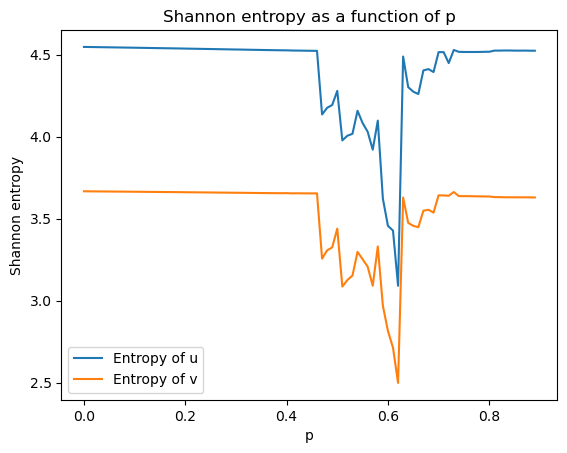

In [ ]:
minu=np.min(results_u)
maxu=np.max(results_u)
#minv=np.min(entropy_v)
#maxv=np.max(entropy_v)
print(np.argmax(results_u))
print(np.argmax(results_v))
plt.plot(np.arange(0,0.90,0.01),results_u,label='Entropy of u')
plt.plot(np.arange(0,0.90,0.01),results_v,label='Entropy of v')
plt.xlabel('p')
plt.ylabel('Shannon entropy')
plt.legend()
plt.title('Shannon entropy as a function of p')
plt.show()
#print(entropy_u)
#print(entropy_v)

# Dominant frequency analysis


In [ ]:
u_sol = sol.ys[:,:N].T 
v_sol = sol.ys[:,N:].T
def dominant_frequency(arr, sampling_rate):
    """
    Computes the dominant frequency (frequency with max amplitude) for each point in a 2D array.

    Parameters:
        arr (ndarray): Input array with shape (N, T), where N is the number of points
                       and T is the time series length for each point.
        sampling_rate (float): Sampling rate of the time series data.

    Returns:
        ndarray: Array of dominant frequencies for each point, shape (N,).
    """
    # Compute Fourier Transform along the temporal axis (axis=1)
    fft_vals = jnp.fft.fft(arr, axis=1)
    
    # Compute the frequency bins
    freqs = jnp.fft.fftfreq(arr.shape[1], d=1/sampling_rate)
    
    # Take the amplitude of the FFT
    amplitude_spectrum = jnp.abs(fft_vals)
    
    # Only take the positive half of frequencies for analysis
    half_length = arr.shape[1] // 2
    freqs = freqs[:half_length]
    amplitude_spectrum = amplitude_spectrum[:, :half_length]
    
    # Find index of the max amplitude for each point
    max_indices = jnp.argmax(amplitude_spectrum, axis=1)
    
    # Map indices to corresponding frequencies
    dominant_freqs = freqs[max_indices]
    
    return dominant_freqs
freq_u=dominant_frequency(u_sol, 2)
freq_v=dominant_frequency(v_sol, 2)

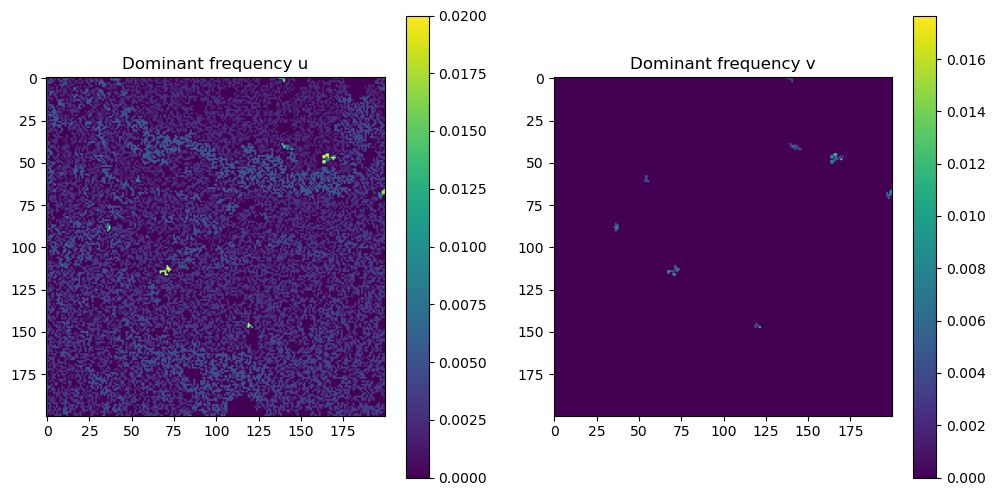

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot freq_u
im1 = axs[0].imshow(freq_u.reshape(N_x, N_y), cmap='viridis')
axs[0].set_title('Dominant frequency u')
fig.colorbar(im1, ax=axs[0])

# Plot freq_v
im2 = axs[1].imshow(freq_v.reshape(N_x, N_y), cmap='viridis')
axs[1].set_title('Dominant frequency v')
fig.colorbar(im2, ax=axs[1])

plt.show()

# Phase and topological charge

In [15]:
# function telling me which points have (u,v)=(0,0) for all t

def zero_mask_over_T(array):
    """
    Returns a mask with True values corresponding to elements in S that are always 0 over T.
    
    Parameters:
    array (numpy.ndarray): Input array of shape (S, T).
    
    Returns:
    numpy.ndarray: Mask of shape (S,) with True values where elements in S are always 0 over T.
    """
    # Check if all elements across the T dimension are zero
    mask = (array == 0).all(axis=1)
    return mask


mask = zero_mask_over_T(u_sol)
print(mask)

[[ True False False ... False False False]
 [False False False ... False False False]
 [ True False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [8]:
#Updated Philip code

def compute_top_charge(phase_data):
    
    rows, cols, frames = phase_data.shape
    
    # Offsets for the 8-point integration path around each point
    k_offsets = [1, 1, 0, -1, -1, -1, 0, 1]
    l_offsets = [0, 1, 1, 1, 0, -1, -1, -1]

    # Define the phase difference function with range [-π, π]
    def phase_difference(theta1, theta2):
        return (jnp.mod(theta1 - theta2 + jnp.pi, 2 * jnp.pi) - jnp.pi)

    # Compute the topological charge at a single point (i, j) for a given frame
    def compute_integral(i, j, phase_frame):
        integral_sum = 0.0

        # Iterate over each segment of the path
        for m in range(8):  
            # Current point in the path
            y1, x1 = i + k_offsets[m], j + l_offsets[m]
            # Next point in the path (wrapping around with (m + 1) % 8)
            y2, x2 = i + k_offsets[(m + 1) % 8], j + l_offsets[(m + 1) % 8]

            # Compute the phase difference along the segment
            diff_theta = phase_difference(phase_frame[y2, x2], phase_frame[y1, x1])
            integral_sum += diff_theta

        # Normalize by 2π to get topological charge in [-1, 1]
        return integral_sum / (2 * jnp.pi)


    def process_frame(t):
        phase_frame = phase_data[:, :, t]

        # Create meshgrid for row and column indices within the frame (ignore boundary points)
        i_coords, j_coords = jnp.meshgrid(jnp.arange(1, rows - 1), jnp.arange(1, cols - 1), indexing='ij')

        compute_integral_vmap = jax.vmap(
            jax.vmap(compute_integral, in_axes=(0, 0, None)),  # Apply over rows (i) and columns (j)
            in_axes=(0, 0, None)  # Matching in_axes for row and column vectors
        )

        # Compute result for each (i, j) in the frame
        result = compute_integral_vmap(i_coords, j_coords, phase_frame)
        return result


    topological_charge = jax.vmap(process_frame)(jnp.arange(frames))
    return topological_charge


In [9]:
def coarse_grain(array, mask):
    """
    Coarse-grain each frame of the 3D array by averaging each node with its 8 neighbors,
    using a 2D mask where `True` indicates invalid values to exclude
    from the average calculation. The mask is applied uniformly across all time frames.
    
    Parameters:
    - array: 3D array of shape (height, width, T), where each (height, width)
             slice along the third dimension represents a frame.
    - mask: 2D boolean array of shape (height, width) where `True` indicates
             values to exclude, and `False` indicates valid values.
    
    Returns:
    - A coarse-grained 3D array of the same shape as `array`.
    """
    # Define a 3x3 filter for counting valid neighbors
    valid_filter = jnp.ones((3, 3, 1, 1))  

    # Add a third axis to the mask to match (height, width, 1)
    mask = mask[..., None] 

    def process_frame(frame):
        # Add an extra dimension to match convolution requirements (height, width, 1)
        frame = frame[..., None]
        
        # Invert mask to interpret True as NaN and False as valid
        inverted_mask = ~mask  
        
        # Replace NaN with 0 for convolution calculation
        frame_no_nan = jnp.where(inverted_mask, frame, 0.0)
        
        # Sum valid values in the 3x3 neighborhood
        sum_values = lax.conv_general_dilated(
            frame_no_nan[None, ...],  # Shape: (1, height, width, 1)
            valid_filter,  # Filter to sum values
            window_strides=(1, 1),  
            padding="SAME",  # Pad to keep original size
            dimension_numbers=('NHWC', 'HWIO', 'NHWC')
        )[0, ..., 0]  # Drop added dims
        
        # Count of valid neighbors based on inverted mask
        count_valid = lax.conv_general_dilated(
            inverted_mask.astype(jnp.float32)[None, ...],  # True->1, False->0 for counting
            valid_filter,  # Same filter to count valid entries
            window_strides=(1, 1),
            padding="SAME",
            dimension_numbers=('NHWC', 'HWIO', 'NHWC')
        )[0, ..., 0]
        
        # Calculate average ignoring invalid
        coarse_grained_frame = sum_values / count_valid
        
        # Set result to NaN where all neighbors are invalid
        coarse_grained_frame = jnp.where(count_valid == 0, jnp.nan, coarse_grained_frame)
        
        # Restore original values outside the mask
        coarse_grained_frame = jnp.where(inverted_mask[..., 0], coarse_grained_frame, frame[..., 0])
        
        return coarse_grained_frame

    # Apply the process_frame function to each frame in the 3D array
    coarse_grained_array = jnp.stack([process_frame(array[..., t]) for t in range(array.shape[-1])], axis=-1)
    
    return coarse_grained_array

In [16]:
## coarse graining with more neighbours
def coarse_grain(array, mask):
    """
    Coarse-grain each frame of the 3D array by averaging each node with its 8 neighbors,
    using a 2D mask where `True` indicates invalid values to exclude
    from the average calculation. The mask is applied uniformly across all time frames.
    
    Parameters:
    - array: 3D array of shape (height, width, T), where each (height, width)
             slice along the third dimension represents a frame.
    - mask: 2D boolean array of shape (height, width) where `True` indicates
             values to exclude, and `False` indicates valid values.
    
    Returns:
    - A coarse-grained 3D array of the same shape as `array`.
    """
    # Define a 3x3 filter for counting valid neighbors
    valid_filter_3x3 = jnp.ones((3, 3, 1, 1))
    # Define a 5x5 filter for counting valid second neighbors
    valid_filter_5x5 = jnp.ones((5, 5, 1, 1))

    # Add a third axis to the mask to match (height, width, 1)
    mask = mask[..., None]

    def process_frame(frame):
        # Add an extra dimension to match convolution requirements (height, width, 1)
        frame = frame[..., None]
        
        # Invert mask to interpret True as NaN and False as valid
        inverted_mask = ~mask
        
        # Replace NaN with 0 for convolution calculation
        frame_no_nan = jnp.where(inverted_mask, frame, 0.0)
        
        # Sum valid values in the 3x3 neighborhood
        sum_values_3x3 = lax.conv_general_dilated(
            frame_no_nan[None, ...],  # Shape: (1, height, width, 1)
            valid_filter_3x3,  # Filter to sum values
            window_strides=(1, 1),  
            padding="SAME",  # Pad to keep original size
            dimension_numbers=('NHWC', 'HWIO', 'NHWC')
        )[0, ..., 0]  # Drop added dims
        
        # Count of valid neighbors based on inverted mask
        count_valid_3x3 = lax.conv_general_dilated(
            inverted_mask.astype(jnp.float32)[None, ...],  # True->1, False->0 for counting
            valid_filter_3x3,  # Same filter to count valid entries
            window_strides=(1, 1),
            padding="SAME",
            dimension_numbers=('NHWC', 'HWIO', 'NHWC')
        )[0, ..., 0]
        
        # Calculate average ignoring invalid
        coarse_grained_frame_3x3 = sum_values_3x3 / count_valid_3x3
        
        # Handle the case where count_valid_3x3 is 0 by using the 5x5 neighborhood
        sum_values_5x5 = lax.conv_general_dilated(
            frame_no_nan[None, ...],  # Shape: (1, height, width, 1)
            valid_filter_5x5,  # Filter to sum values
            window_strides=(1, 1),  
            padding="SAME",  # Pad to keep original size
            dimension_numbers=('NHWC', 'HWIO', 'NHWC')
        )[0, ..., 0]  # Drop added dims
        
        count_valid_5x5 = lax.conv_general_dilated(
            inverted_mask.astype(jnp.float32)[None, ...],  # True->1, False->0 for counting
            valid_filter_5x5,  # Same filter to count valid entries
            window_strides=(1, 1),
            padding="SAME",
            dimension_numbers=('NHWC', 'HWIO', 'NHWC')
        )[0, ..., 0]
        
        coarse_grained_frame_5x5 = sum_values_5x5 / count_valid_5x5
        
        # Use 5x5 average where 3x3 average is invalid
        coarse_grained_frame = jnp.where(count_valid_3x3 == 0, coarse_grained_frame_5x5, coarse_grained_frame_3x3)
        
        # Set result to NaN where all neighbors are invalid in both 3x3 and 5x5
        coarse_grained_frame = jnp.where((count_valid_3x3 == 0) & (count_valid_5x5 == 0), jnp.nan, coarse_grained_frame)
        
        # Restore original values outside the mask
        coarse_grained_frame = jnp.where(inverted_mask[..., 0], coarse_grained_frame, frame[..., 0])
        
        return coarse_grained_frame

    # Apply the process_frame function to each frame in the 3D array
    coarse_grained_array = jnp.stack([process_frame(array[..., t]) for t in range(array.shape[-1])], axis=-1)
    
    return coarse_grained_array


# this seems to avoid nan values at the moment. Good. But thing is that I can't get arrhythmias for 
# Du<0.4 so I have a super thin front anyway.

# Coarse graining

In [17]:
u_sol=u_sol.reshape(N_x, N_y, dts)
v_sol=v_sol.reshape(N_x, N_y, dts)

u_coarse_grained = coarse_grain(u_sol, c1)
u_coarse_grained = u_coarse_grained.reshape(N_x*N_y, -1)


v_coarse_grained = coarse_grain(v_sol, c1)
v_coarse_grained = v_coarse_grained.reshape(N_x*N_y, -1)


In [30]:
# Check for NaN values in u_coarse_grained

if jnp.isnan(u_coarse_grained).any():
    print("NaN values found in u_coarse_grained")

# Check for NaN values in v_coarse_grained
if jnp.isnan(v_coarse_grained).any():
    print("NaN values found in v_coarse_grained")

In [38]:
from scipy.ndimage import gaussian_filter
def smooth_array(array, sigma=1):
    """
    Smoothen the 3D array using a 2D Gaussian kernel.
    
    Parameters:
    - array: 3D array of shape (height, width, T), where each (height, width)
             slice along the third dimension represents a frame.
    - sigma: Standard deviation for Gaussian kernel.
    
    Returns:
    - A smoothed 3D array of the same shape as `array`.
    """
    def smooth_frame(frame):
        return gaussian_filter(frame, sigma=sigma)
    
    smoothed_array = jnp.stack([smooth_frame(array[..., t]) for t in range(array.shape[-1])], axis=-1)
    
    return smoothed_array

In [21]:
import jax.numpy as jnp
from scipy.ndimage import gaussian_filter

def smooth_array_with_mask(array, mask, sigma=1):
    """
    Smoothen the 3D array using a 2D Gaussian kernel, excluding invalid points from influencing the smoothing.
    
    Parameters:
    - array: 3D array of shape (height, width, T), where each (height, width)
             slice along the third dimension represents a frame.
    - mask: 2D boolean array of shape (height, width) where `True` indicates
             values to exclude, and `False` indicates valid values.
    - sigma: Standard deviation for Gaussian kernel.
    
    Returns:
    - A smoothed 3D array of the same shape as `array`.
    """
    def smooth_frame(frame, mask):
        # Ensure the mask has the same shape as the frame
        mask = mask[..., None]
        
        # Invert mask to interpret True as invalid and False as valid
        inverted_mask = ~mask
        
        # Replace invalid values with 0 for convolution calculation
        frame_no_nan = jnp.where(inverted_mask, frame, 0.0)
        
        # Apply Gaussian filter to the frame
        smoothed_frame = gaussian_filter(frame_no_nan, sigma=sigma)
        
        # Apply Gaussian filter to the mask to get the influence of valid points
        mask_float = inverted_mask.astype(jnp.float32)
        smoothed_mask = gaussian_filter(mask_float, sigma=sigma)
        
        # Normalize the smoothed frame by the smoothed mask to exclude invalid points
        normalized_frame = jnp.where(inverted_mask, smoothed_frame / smoothed_mask, 0.0)
        
        return normalized_frame

    # Process all frames at once
    num_frames = array.shape[-1]
    smoothed_array = jnp.stack([smooth_frame(array[..., t], mask) for t in range(num_frames)], axis=-1)
    
    return smoothed_array


In [ ]:

print(u_sol.shape)
print(v_sol.shape)
c1=c1.reshape(N_x, N_y)
print(c1.shape)
u_smoothed = smooth_array_with_mask(u_sol, c1, sigma=0.5)
v_smoothed = smooth_array_with_mask(v_sol, c1, sigma=0.5)

(200, 200, 3000)
(200, 200, 3000)
(200, 200)


(40000,)


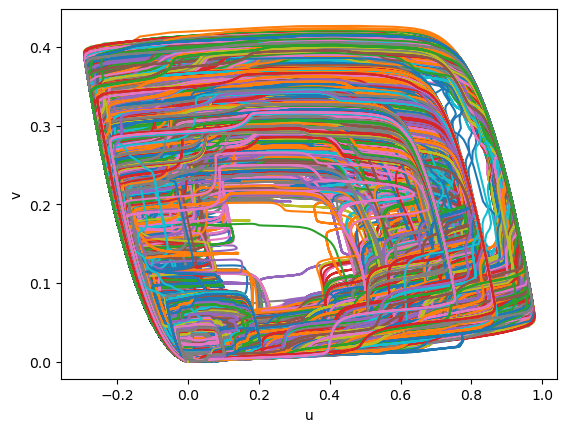

40000


In [ ]:
c1 = c1.flatten()
print(c1.shape)
#u_plot = np.array(u_coarse_grained[~c1, :])
#v_plot = np.array(v_coarse_grained[~c1, :])
u_plot = np.array(u_smoothed)
v_plot = np.array(v_smoothed)
# Plotting function
def plot_uv(u, v):
    plt.plot(u, v)  

# Plot each (u, v) pair for a subsample
#subsample_indices = np.random.choice(len(u_plot), size=100, replace=False)
for idx in range(len(u_plot)):
    plot_uv(u_plot[idx], v_plot[idx])

plt.xlabel('u')
plt.ylabel('v')
plt.show()
print(len(u_plot))

In [72]:
theta= jnp.arctan2(u_smoothed-0.3, v_smoothed-0.14)
'''
print(theta.shape)
theta1=smooth_array(theta.reshape(200,200, 3000), sigma=2)

fig, axs = plt.subplots(1,9,figsize=(30,4))
min = theta1.min()
max = theta1.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(theta1[:,:, int((i/len(axs)*len(sol.ts)))], vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])
'''

"\nprint(theta.shape)\ntheta1=smooth_array(theta.reshape(200,200, 3000), sigma=2)\n\nfig, axs = plt.subplots(1,9,figsize=(30,4))\nmin = theta1.min()\nmax = theta1.max()\nfor i, ax in enumerate(axs[:-1]):\n    im = ax.imshow(theta1[:,:, int((i/len(axs)*len(sol.ts)))], vmin=min,vmax=max)\naxs[-1].axis('off')\nfig.colorbar(im, ax=axs[-1])\n"

In [73]:
theta=theta.reshape(200,200,3000)
top_charge=compute_top_charge(theta)

In [74]:
print(np.max(top_charge))

2.0000002


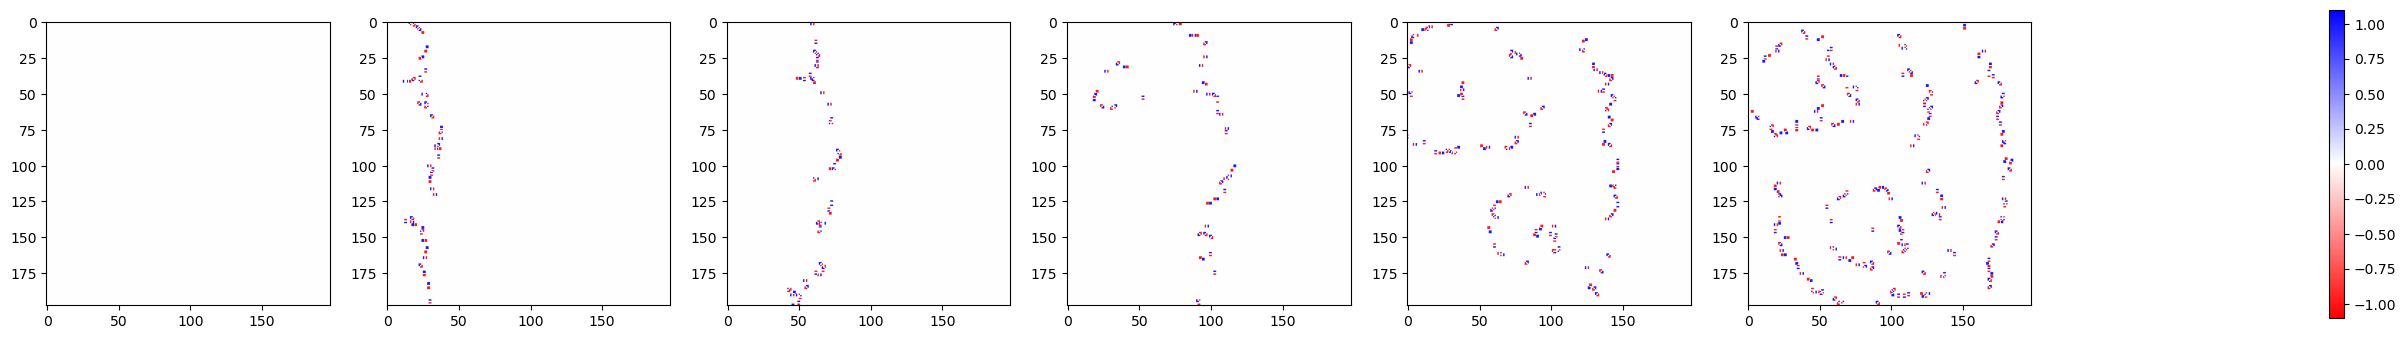

In [76]:
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap that transitions from red to white to blue
colors = [(1, 0, 0),  # Red for negative values
          (1, 1, 1),  # White at zero
          (0, 0, 1)]  # Blue for positive values

# Create the colormap with three defined colors
cmap = LinearSegmentedColormap.from_list('custom_white_zero', colors, N=256)

fig, axs = plt.subplots(1, 7, figsize=(30, 4))
min_val = -1.1
max_val = 1.1

# Normalize the colormap to ensure white is exactly at zero
norm = plt.Normalize(vmin=min_val, vmax=max_val)
top_charge=top_charge
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(top_charge[int((i/len(axs)*len(sol.ts))), :, :], cmap=cmap, norm=norm)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])
plt.savefig("top_charge_philip.png")
plt.show()

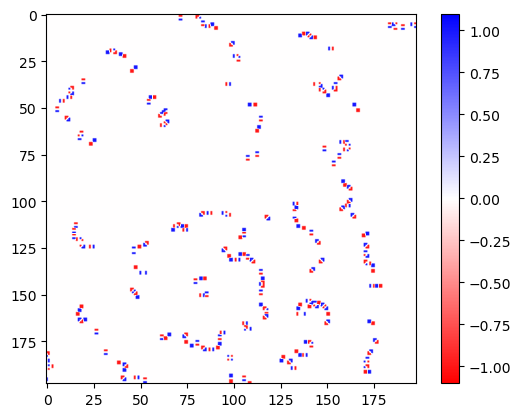

In [77]:
plt.imshow(top_charge[2611,:,:], cmap=cmap, norm=norm)
plt.colorbar()
print()

In [ ]:
#functions to debug the topological charge calculations

def count_elements_above_threshold(array, threshold):


    count = np.sum(np.abs(array) > threshold)
    return count


threshold = 2
count = count_elements_above_threshold(top_charge, threshold)
print(count)

176


In [20]:
print(np.max(top_charge[0,:,:]))

1.5178198e-07


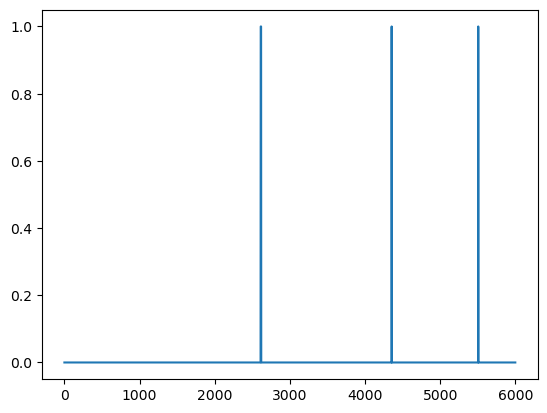

In [ ]:
#count of singularities: just counts how many singularities are there because of transient wavebreaks and not because of actual spirals

def count_coupled_clusters(top_charge, threshold=1, eps=4, min_samples=1):
    """
    Count coupled clusters of negative and positive topological charges in each frame.

    Parameters:
    - top_charge: 3D array (T, N, N) with topological charges.
    - threshold: Minimum absolute value of topological charge to be considered significant.
    - eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    - min_samples: The number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
    - coupled_cluster_counts: List of coupled cluster counts per frame.
    """
    T, N, _ = top_charge.shape
    coupled_cluster_counts = []

    for t in range(T):
        frame = top_charge[t, :, :]
        
        # Find indices of significant charges
        significant_mask = np.abs(frame) > threshold
        indices = np.column_stack(np.nonzero(significant_mask))
        charges = frame[significant_mask]
        
        if len(indices) == 0:
            coupled_cluster_counts.append(0)
            continue
        
        # Apply DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(indices)
        labels = clustering.labels_
        
        # Count clusters with both positive and negative charges
        unique_clusters = np.unique(labels)
        cluster_count = 0
        
        for cluster in unique_clusters:
            if cluster == -1:
                continue  # Skip noise points
            
            cluster_charges = charges[labels == cluster]
            has_positive = np.any(cluster_charges > 0)
            has_negative = np.any(cluster_charges < 0)
            
            if has_positive and has_negative:
                cluster_count += 1
        
        coupled_cluster_counts.append(cluster_count)
    
    return coupled_cluster_counts



coupled_cluster_counts = count_coupled_clusters(top_charge, threshold=1.3)
plt.plot(coupled_cluster_counts)

In [ ]:
a=np.nonzero(count_coupled_clusters)[0]

print(a)

[2611 2612 2613 2614 2615 2616 2617 4354 5506]


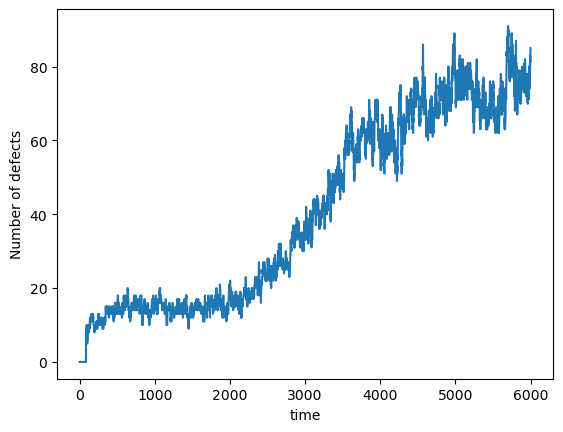

In [27]:
plt.plot(coupled_cluster_counts)
plt.xlabel('time')
plt.ylabel('Number of defects')
plt.savefig('Number_defects_trial.png')

# Entropy and co 

In [ ]:
def shannon_entropy(u_sol):
    # Perform the 3D shifted Fourier transform
    u_sol_fft = np.fft.fftshift(np.fft.fftn(u_sol.reshape(N_x, N_y, -1)))
#Shannon entropy
    power_sp= np.abs(u_sol_fft)**2
    power_norm=power_sp/np.sum(power_sp)
    entropy=-np.sum(power_norm*np.log(power_norm))
    return entropy

# Defining the right boundary of the frame
lista=[]
N=200*200
for i in range(N):
    if i%N_x==N_x-1:
        lista.append(i)
#defining function to calculate the 'velocity' of the wave
def tempi(u_sol, dts):
    a=0
    for j in range(dts):

        u1=np.array(u_sol[:,j])
        for i in lista:
            if u1[i]!=0:
                a=1
                return j
    if a==0:
        return dts  #returns the last time if the wave doesn't reach the right boundary
    


def conditional_entropy(u_sol):
    u_sol_fft = np.fft.fftshift(np.fft.fftn(u_sol.reshape(N_x, N_y, -1)))
    power_sp = np.abs(u_sol_fft)**2
    power_norm = power_sp / np.sum(power_sp)
    p_k = np.sum(power_norm, axis=2)
    p_k[p_k == 0] = np.finfo(float).eps

    marginal_kx_ky_expanded = np.expand_dims(p_k, axis=2)
    conditional_distribution = power_norm / marginal_kx_ky_expanded
    conditional_entropy = 0.0

    for kx in range(conditional_distribution.shape[0]):
        for ky in range(conditional_distribution.shape[1]):
            p_omega_given_k = conditional_distribution[kx, ky]
            p_omega_given_k_nonzero = p_omega_given_k[p_omega_given_k > 0]
            entropy_term = -np.sum(p_omega_given_k_nonzero * np.log(p_omega_given_k_nonzero))
            conditional_entropy += p_k[kx, ky] * entropy_term

    return conditional_entropy



In [ ]:
u_sol=[]
entropy_u=[]
entropy_v=[]
frames=[]

D=0
N_y=200
for d in range(40):
    L1, c1=generate_laplacian(N_x, N_y, conduction_block_threshold=D,boundary_condition="no-flux",sparse_matrix=True, seed=d)
    sol= solve_heart(T=3000,a=3, b=0.05, Du=0.04, L=L1)
    u_sol=sol.ys[:,:N].T
    v_sol=sol.ys[:,N:].T
 
    entropy_u.append(shannon_entropy(u_sol))
    entropy_v.append(shannon_entropy(v_sol))
    frames.append(tempi(u_sol,dts))
    D+=0.02


32


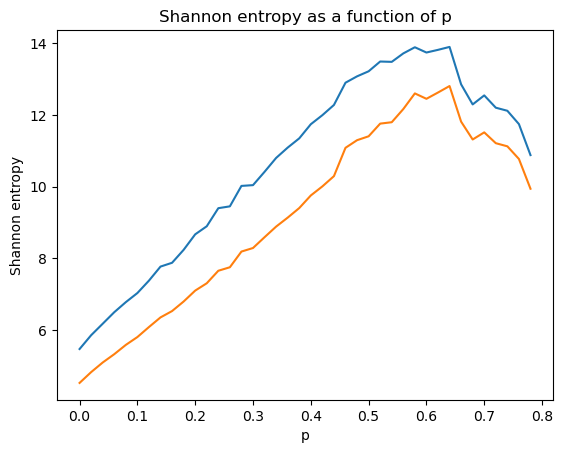

[5.47126788666964, 5.856433846539968, 6.176653276118139, 6.498541812827065, 6.779239988445151, 7.033138183509885, 7.3794143274343735, 7.771164702085293, 7.877434300795918, 8.23843648358658, 8.670606795385815, 8.896152297356759, 9.400615286269698, 9.451823530803686, 10.022168779732127, 10.043566117606838, 10.415586011619554, 10.802482042679882, 11.09080983543932, 11.348743571769232, 11.742889396033531, 11.995542271981138, 12.28056726135333, 12.901477930253979, 13.079015432426155, 13.219942492865718, 13.492477212920102, 13.48302288122614, 13.718921183348709, 13.89052083681153, 13.743488859501069, 13.818101661558629, 13.89980003419093, 12.85580621996821, 12.295509341066381, 12.54722771265402, 12.204217971579988, 12.118430702072416, 11.7467098962782, 10.881616069490661]


In [8]:
minu=np.min(entropy_u)
maxu=np.max(entropy_u)
#minv=np.min(entropy_v)
#maxv=np.max(entropy_v)
print(np.argmax(entropy_u))
#print(np.argmax(entropy_v))
plt.plot(np.arange(0,0.80,0.02),entropy_u,label='Entropy of u')
plt.plot(np.arange(0,0.80,0.02),entropy_v,label='Entropy of v')
plt.xlabel('p')
plt.ylabel('Shannon entropy')
#plt.legend()
plt.title('Shannon entropy as a function of p')
plt.show()
print(entropy_u)
#print(entropy_v)

19


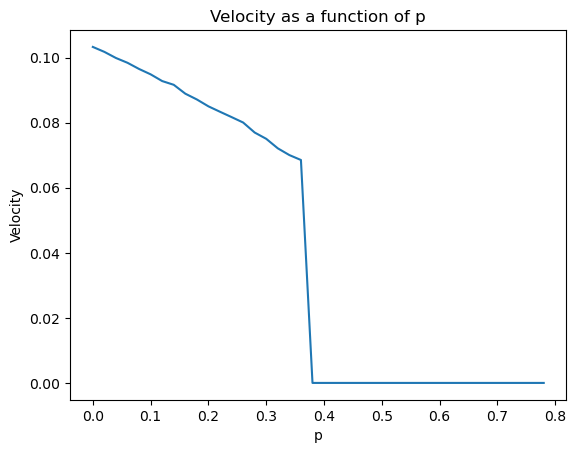

In [ ]:
frames=np.array(frames)

velocity = np.where(frames != dts, 200 / frames, 0) #set velocity to zero for waves which did not reach the end of the frame
plt.plot(np.arange(0,0.80,0.02),velocity)
plt.xlabel('p')
plt.ylabel('Velocity')
plt.title('Velocity as a function of p')
print(np.argmin(velocity))


## Fourier transform and order parameters
1) 3D Fourier transform : power spectrum concentration

In [ ]:
#dominant wavenumber and power spectrum concentration
def dominant_wavenumber(u_sol_fft):
    power_sp= np.abs(u_sol_fft)**2
    kmax=np.argmax(power_sp)
    kmax_2d = np.unravel_index(kmax, power_sp.shape)
    psi=power_sp[kmax_2d]/ np.sum(power_sp)
    return psi


0.022233007623218153


## 2D Fourier transform

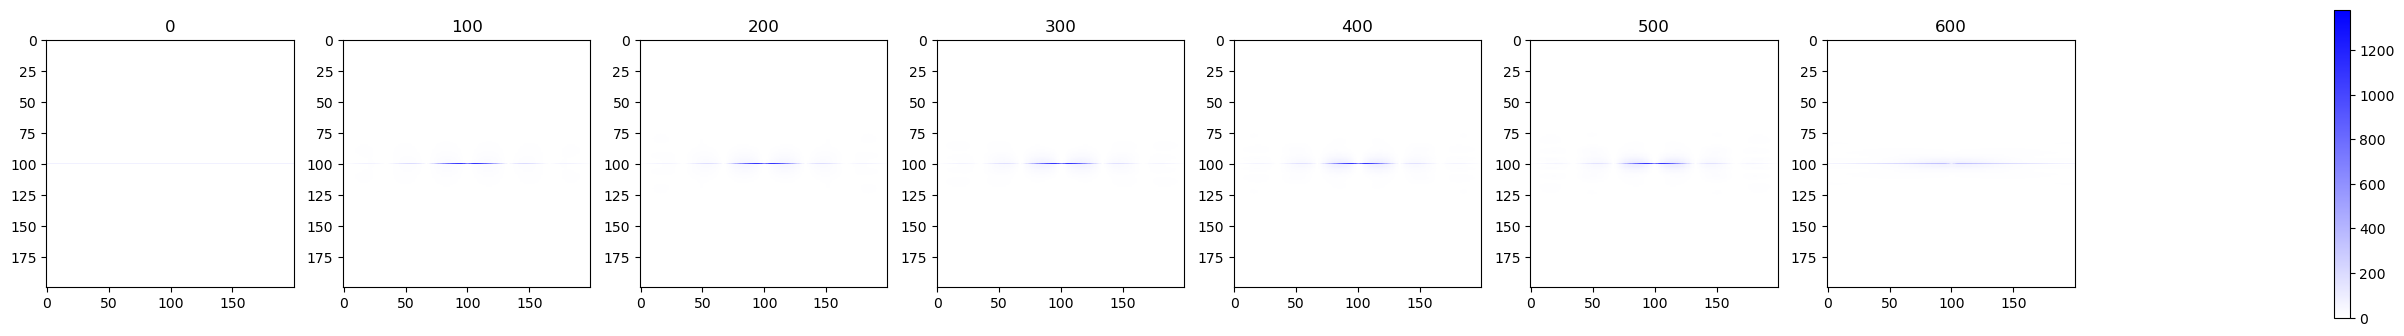

In [69]:

u_sol = sol.ys[:,:N].T 
# Perform the 2D Fourier transform on each temporal frame
u_sol_fft = np.fft.fftshift(np.fft.fft2(u_sol.reshape(N_x, N_y, -1), axes=(0, 1)), axes=(0, 1))

# Plot the 2D Fourier transform as a function of time
fig, axs = plt.subplots(1, 8, figsize=(30, 4))
min_val = np.abs(u_sol_fft).min()
max_val = np.abs(u_sol_fft).max()

for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(np.abs(u_sol_fft[:, :, int(i / len(axs) * u_sol_fft.shape[2])]), vmin=min_val, vmax=max_val, cmap=cmap, interpolation='nearest')
    ax.set_title(str(int(i / len(axs) * u_sol_fft.shape[2])))
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])
plt.show()
v_sol = sol.ys[:,N:].T 


## 2D Fourier transform of the u averaged over the y axis

(200, 200, 800)


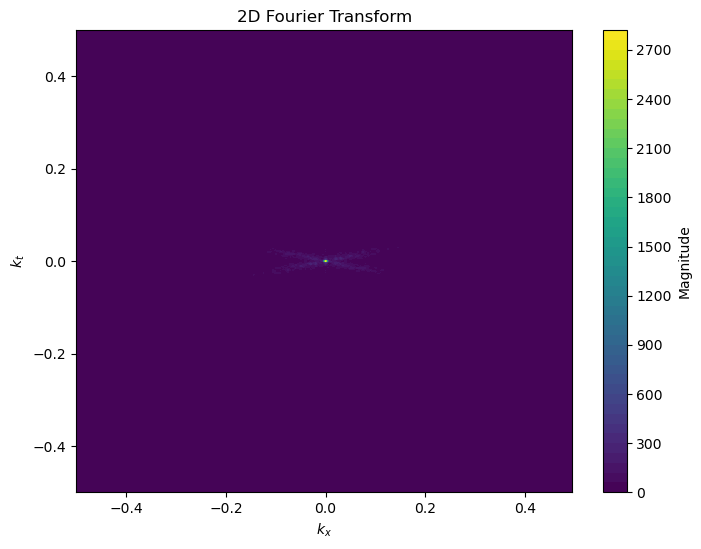

In [9]:
u_sol = sol.ys[:,:N].T 
u_p=u_sol.reshape(N_x, N_y, -1)
print(u_p.shape)
T=800
# Compute the mean of u_p over the y-axis for each timestep
matrix = np.mean(u_p, axis=1)

# Step 1: Compute the 2D Fourier Transform
fft_matrix = np.fft.fft2(matrix)

# Step 2: Shift the zero-frequency component to the center
fft_shifted = np.fft.fftshift(fft_matrix)

# Step 3: Calculate the Fourier space frequencies
kx = np.fft.fftshift(np.fft.fftfreq(N_x))
kt = np.fft.fftshift(np.fft.fftfreq(T))

# Step 4: Create the grid of Fourier space coordinates
KX, KT = np.meshgrid(kx, kt, indexing='ij')

# Step 5: Plot the magnitude of the shifted Fourier transform
plt.figure(figsize=(8, 6))
plt.contourf(KX, KT, np.abs(fft_shifted), levels=50, cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('2D Fourier Transform')
plt.xlabel(r'$k_{x}$')
plt.ylabel(r'$k_{t}$ ')
plt.show()

In [34]:
#dominant wavenumber and power spectrum concentration
power_sp= np.abs(fft_shifted)**2
kmax=np.argmax(power_sp)
kmax_2d = np.unravel_index(kmax, power_sp.shape)
psi=power_sp[kmax_2d]/ np.sum(power_sp)
print(psi)

psi1=0.39514010945587014
psi2=0.678211870040056

0.678211870040056
